<div align="right">MIT Big Data and Social Analytics</div>

# Collecting and visualizing World Bank Data
In this example, we look for interesting data in the world bank to visualize.

In [1]:
import pandas as pd
from pandas_datareader import wb # to import world bank data
import numpy as np
import matplotlib.pylab as plt
import matplotlib
import folium # for plotting on maps
import geocoder # on pypi, to easily get lat,long data
import wikipedia # to get gata from wikipedia

#set plot options
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 8)

In [2]:
# search world bank indicators for average caloric intake
wb.search('calories')

,id,name,source,sourceNote,sourceOrganization,topics
10280,SN.ITK.DFCT,Depth of the food deficit (kilocalories per pe...,World Development Indicators,The depth of the food deficit indicates how ma...,"b'Food and Agriculture Organization, Food Secu...",Health
10281,SN.ITK.DPTH,Depth of hunger (kilocalories per person per day),Africa Development Indicators,Depth of hunger or the intensity of food depri...,"b'Food and Agriculture Organization, Food Secu...",Health


### Look at the returned hits
It looks like id SN.ITK.DFCT has data about caloric deficits.  Since I find this this interesting, this is what I'll look it.  After North Korea's recent request to the UN for aid after the earthquake hit, I began to wonder how wide spread food shortages are.

Average over the 10 years 2006-2015 and visualize.



In [3]:
# select caloric deficit as indicator
wb_indicator = 'SN.ITK.DFCT'

# choose start and end years of data
start_year = 2006
end_year = 2015

# download data set from world bank
foodDef_df = wb.download(indicator = wb_indicator,
                  country = ['all'],
                  start = start_year,
                  end = end_year)

In [4]:
# preview dataset
foodDef_df.sample(n=10)

# rename SN.ITK.DFCT to caloric deficit
foodDef_df.rename(columns={'SN.ITK.DFCT':'caloricDeficit'},inplace=True)
# drop NaN's
foodDef_df.dropna(inplace=True)
# collapse column indices
foodDef_df.reset_index(inplace=True)
# preview once more
foodDef_df.sample(n=10)

,country,year,caloricDeficit
128,Late-demographic dividend,2013,79.253485
1209,Sao Tome and Principe,2013,35.000000
1262,South Africa,2010,26.000000
1331,Tanzania,2007,263.000000
69,Heavily indebted poor countries (HIPC),2012,187.565850
852,Kazakhstan,2010,21.000000
1238,Sierra Leone,2014,169.000000
772,Haiti,2010,524.000000
934,Lebanon,2008,27.000000
976,Malawi,2006,189.000000


In [5]:
# compute statistics
foodDef_gbCountry = foodDef_df.groupby('country')
foodDefStats_df = foodDef_gbCountry.agg({'caloricDeficit': [np.mean]}).reset_index()
# Note: the .reset_index() method collapses the 3 levels of indices to 2
foodDefStats_df.sample(n=10)

,country,caloricDeficit
,,mean
26,Costa Rica,37.700000
128,Sudan,171.666667
93,Middle income,99.648974
135,Togo,136.000000
44,Ghana,46.300000
46,Guinea,135.400000
33,East Asia & Pacific (IDA & IBRD countries),103.965214
59,"Iran, Islamic Rep.",45.400000
130,Swaziland,155.000000


### spot check
There is some house-cleaning to do with the double levels at the top.

In [6]:
# drop level=1 labeled row and rename 2nd column
foodDefStats_df.columns = foodDefStats_df.columns.droplevel(1)
foodDefStats_df.rename(columns={'caloricDeficit':'meanCaloricDeficit'},inplace=True)
foodDefStats_df.sample(n=10)

,country,meanCaloricDeficit
3,Arab World,66.87245
124,St. Vincent and the Grenadines,54.00000
20,Central African Republic,287.00000
45,Guatemala,97.40000
108,Paraguay,79.40000
123,Sri Lanka,234.80000
112,Rwanda,295.90000
62,Jordan,12.50000
107,Panama,116.00000
59,"Iran, Islamic Rep.",45.40000


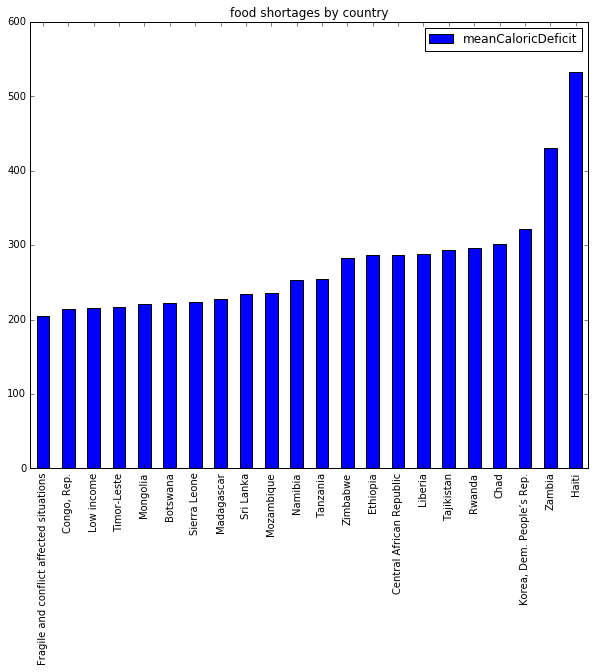

In [7]:
# Visualize differences in food shortages by severity
foodDefStats_df.sort_values('meanCaloricDeficit',ascending=True,inplace=True)

# only pick up the rougher shortages (since there are too many already)
foodDefHigh_df = foodDefStats_df.loc[ foodDefStats_df.loc[:,'meanCaloricDeficit'] > 200 ]
ax = foodDefHigh_df.plot(kind='bar')
ax.set_title('food shortages by country')
ax.set_xticklabels(foodDefHigh_df.country)

### Questions and answers
Of course, measuring caloric deficits is not something easy to do, so the bar plot about is only suggestive.  Haiti was severely hit by an earthquake a few years ago and my by the reason it has such high food shortages.  This can be investigated further by comparing caloric deficit before and after the earthquake.

In [8]:
# world map using folium
# for convenience:
df = foodDefHigh_df.reset_index(drop=True)
# add latitude and longitude information to dataframe
    # create two additional columns for lattitude and longitude.
df['lat'], df['lng'] = [0, 0]
    # convert country to lat and long coordinates
df.head()
for i in range(len(df)):
    g = geocoder.google(df.loc[i,'country'])
    df.ix[i,'lat'] = g.lat
    df.ix[i,'lng'] = g.lng

# drop cases where the country could not be geocoded
df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)
df.head()

,country,meanCaloricDeficit,lat,lng
0,"Congo, Rep.",213.700000,-4.304398,15.312098
1,Low income,215.498774,45.881249,-98.153458
2,Timor-Leste,217.100000,-8.874217,125.727539
3,Mongolia,221.000000,46.862496,103.846656
4,Botswana,222.600000,-22.328474,24.684866


In [9]:
# Set map center and zoom level
mapc = [0, 30] # in [latitude,longitude]
zoom = 2

# Create map object.
map_osm = folium.Map(location=mapc,
#                     tiles='Stamen Toner',
                    zoom_start=zoom)
print("length of df = {:} ".format(len(df)))

# Plot each of the locations that we geocoded.
for j in range(len(df)):
    # Plot a red circle marker for country food shortage.
    folium.CircleMarker([df.lat[j], df.lng[j]],
                    radius=df.meanCaloricDeficit[j]*1e3,
                    popup='meanCaloricDeficit',
                    color='red',
                    fill_color='red',
                   ).add_to(map_osm)

# Show the map.
map_osm


length of df = 20 


### Fun with folium
The folium package is an easy module to use for plotting data on earth.  This is nice for prsentations and web graphics.